In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import os
import librosa

#AudioSegment.converter = r"C:\tools\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
#AudioSegment.ffmpeg = r"C:\tools\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
#AudioSegment.ffprobe = r"C:\tools\ffmpeg-master-latest-win64-gpl\bin\ffprobe.exe"

DATASET_BASE_FILE_PATH = r"D:\kaggle_competition\birdclef-2023"
TRAIN_SET_FILE_DIR = r"\train_audio"
TEST_SET_FILE_DIR = r"\test_soundscapes"
SAMPLE_SUBMISSION_FILE_PATH = r"\sample_submission.csv"

train_metadata = pd.read_csv(DATASET_BASE_FILE_PATH + r"\train_metadata.csv")
sample_submission = pd.read_csv(DATASET_BASE_FILE_PATH + SAMPLE_SUBMISSION_FILE_PATH)
ebird_taxonomy = pd.read_csv(DATASET_BASE_FILE_PATH + r"\ebird_Taxonomy_v2021.csv")


# Data exploration

In [2]:
train_metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [3]:
sample_submission.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
ebird_taxonomy.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


## Distribution of Bird Species

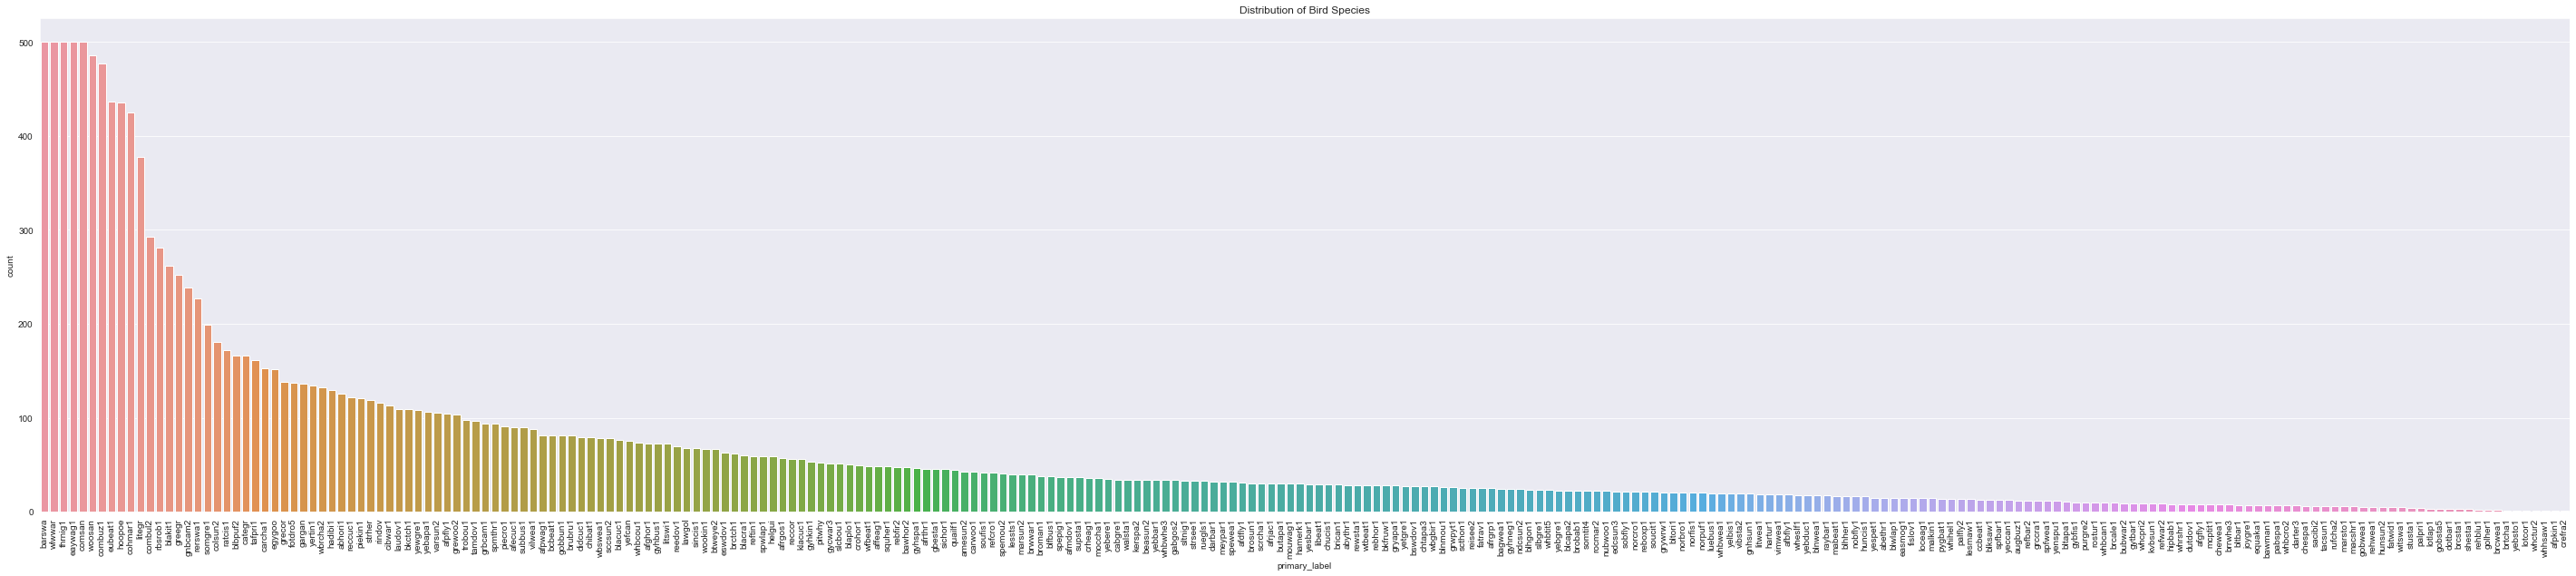

In [5]:
plt.figure(figsize=(50, 10))
sns.countplot(data=train_metadata, x='primary_label', order=train_metadata['primary_label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Bird Species')
plt.show()

## Geographic distribution

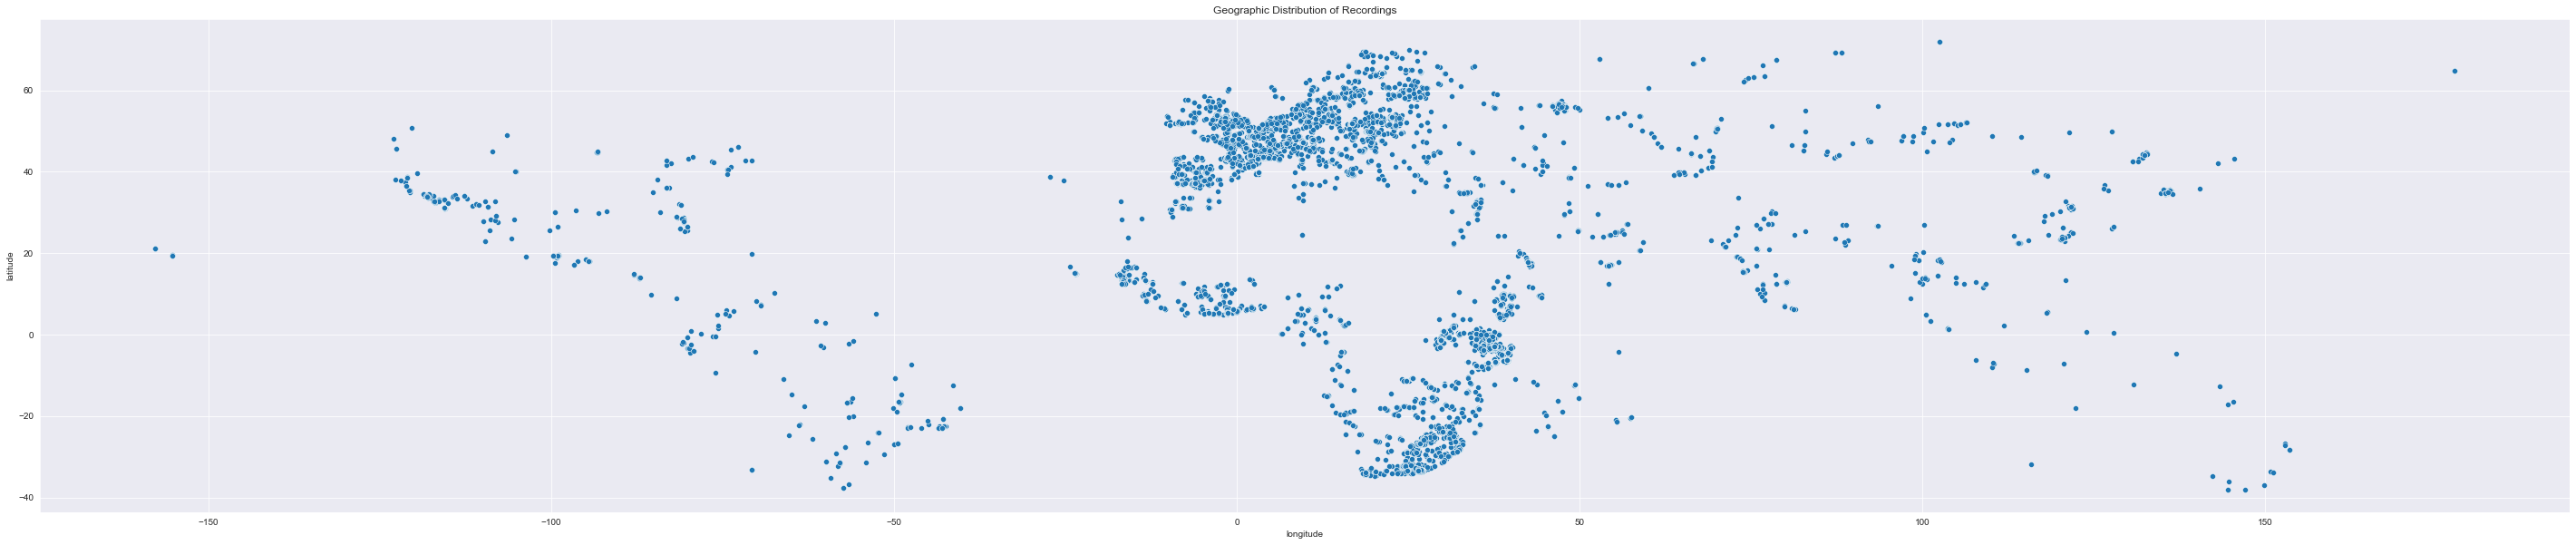

In [6]:
plt.figure(figsize=(50, 10))
sns.scatterplot(data=train_metadata, x='longitude', y='latitude')
plt.title('Geographic Distribution of Recordings')
plt.show()

## Distribution of Recordings by Author

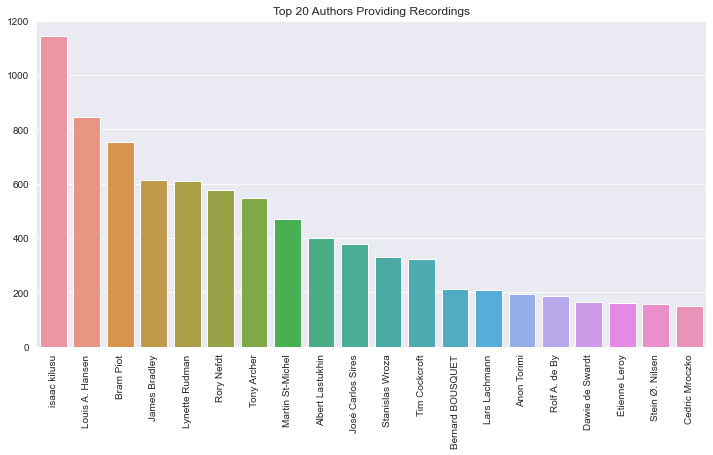

In [7]:
def plot_author_distribution(train_metadata):
    plt.figure(figsize=(12, 6))
    top_authors = train_metadata['author'].value_counts().head(20)
    sns.barplot(x=top_authors.index, y=top_authors.values)
    plt.xticks(rotation=90)
    plt.title('Top 20 Authors Providing Recordings')
    plt.show()

plot_author_distribution(train_metadata)

## Distribution of Recording Ratings

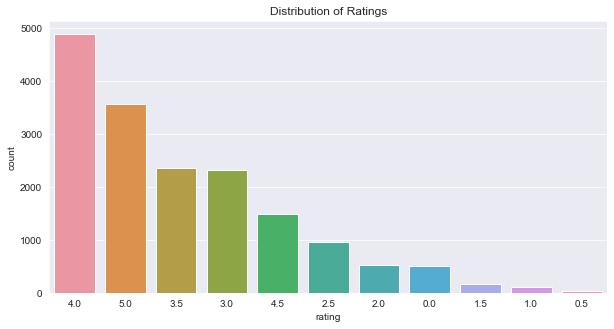

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_metadata, x='rating', order=train_metadata['rating'].value_counts().index)
plt.title("Distribution of Ratings")
plt.show()

## Explore the distribution of recording types

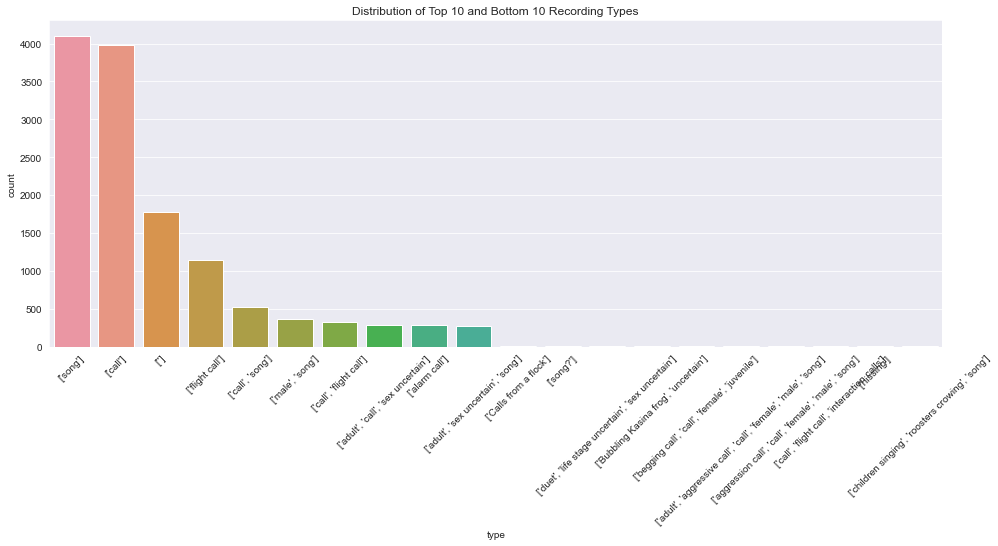

In [9]:
#train_metadata['type'] = train_metadata['type'].apply(lambda x: eval(x))
#train_metadata = train_metadata.explode('type')
#plt.figure(figsize=(50, 5))
#sns.countplot(data=train_metadata, x='type', order=train_metadata['type'].value_counts().index)
#plt.title("Distribution of Recording Types")
#plt.show()

# Get the top 10 most frequent and least frequent recording types
top_10_types = train_metadata['type'].value_counts().nlargest(10).index
bottom_10_types = train_metadata['type'].value_counts().nsmallest(10).index
selected_types = top_10_types.union(bottom_10_types)

# Filter the train_metadata DataFrame to include only the selected types
filtered_train_metadata = train_metadata[train_metadata['type'].isin(selected_types)]

# Plot the selected recording types
plt.figure(figsize=(16, 6))
sns.countplot(data=filtered_train_metadata, x='type', order=filtered_train_metadata['type'].value_counts().index)
plt.title("Distribution of Top 10 and Bottom 10 Recording Types")
plt.xticks(rotation=45)
plt.show()

## Analyze the distribution of bird occurrences by class of latitude and longitude

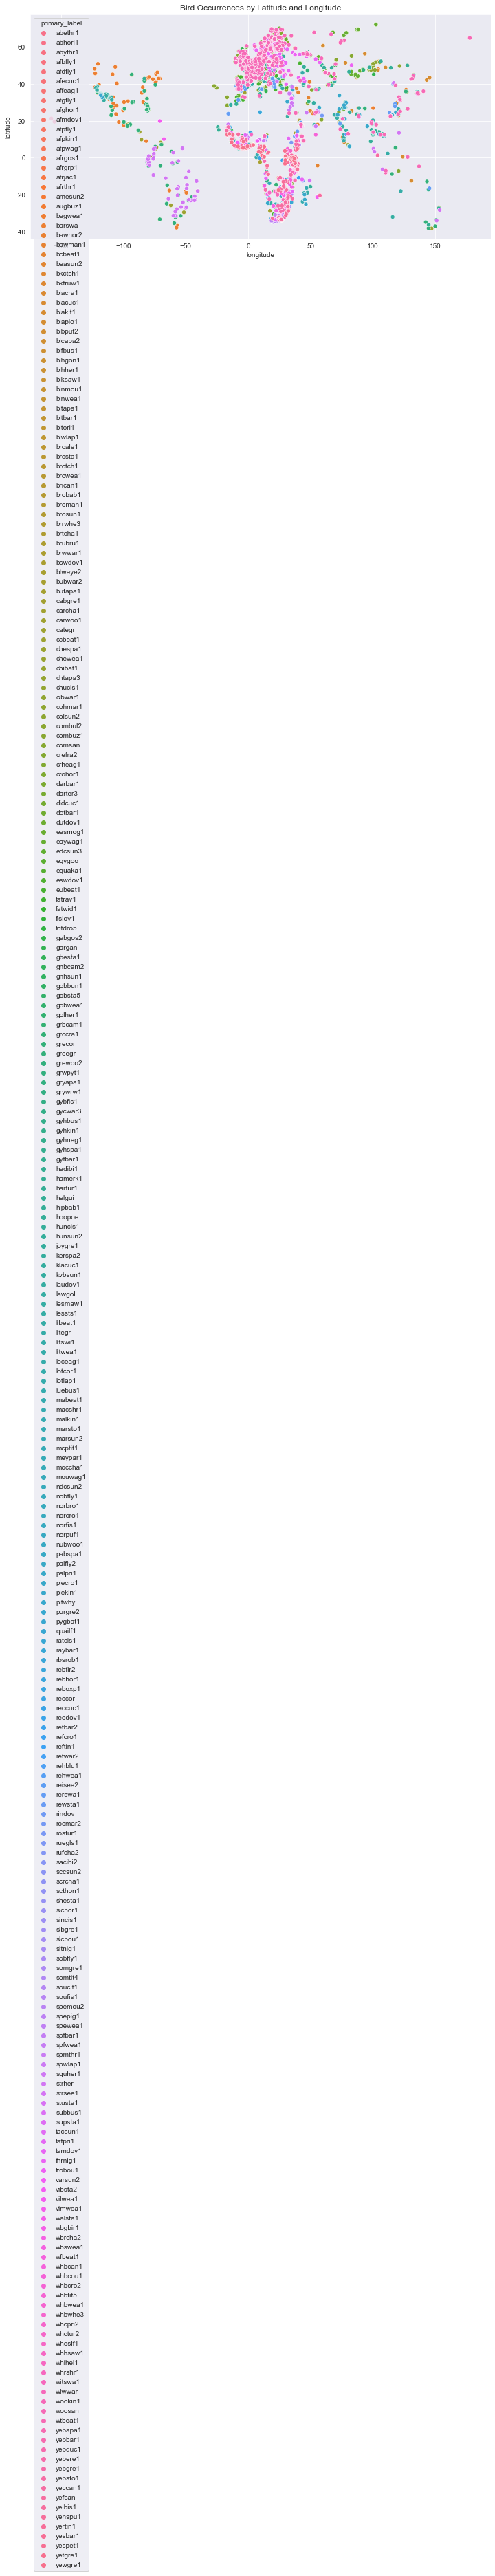

In [10]:
def plot_bird_occurrences_by_lat_long(train_metadata):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=train_metadata, x='longitude', y='latitude', hue='primary_label')
    plt.title('Bird Occurrences by Latitude and Longitude')
    plt.show()
plot_bird_occurrences_by_lat_long(train_metadata)

In [11]:
## Visualize the distribution of audio file durations

In [12]:
def get_audio_duration(file_path):
    try:
        audio_data, _ = librosa.load(file_path, sr=None, mono=True)
        duration = librosa.get_duration(y=audio_data)
        return duration
    except Exception as e:
        print(e)
        return None

In [ ]:
train_audio_folder = os.path.join(DATASET_BASE_FILE_PATH, "train_audio")
train_metadata['file_path'] = train_metadata.apply(lambda row: os.path.join(train_audio_folder, row['filename']), axis=1)

durations = train_metadata['file_path'].apply(get_audio_duration)
train_metadata['duration'] = durations

plt.figure(figsize=(10, 5))
sns.histplot(train_metadata['duration'].dropna(), kde=True)
plt.title("Distribution of Audio File Durations")
plt.show()

## Plot the distribution of audio file durations by most/least frequent bird species

In [35]:
# Sort classes by the number of occurrences
class_counts = train_metadata['primary_label'].value_counts()
top_5_classes = class_counts.head(5).index
last_5_classes = class_counts.tail(5).index

# Calculate mean duration for each class
mean_durations_top = train_metadata[train_metadata['primary_label'].isin(top_5_classes)].groupby('primary_label')['duration'].mean()
mean_durations_last = train_metadata[train_metadata['primary_label'].isin(last_5_classes)].groupby('primary_label')['duration'].mean()

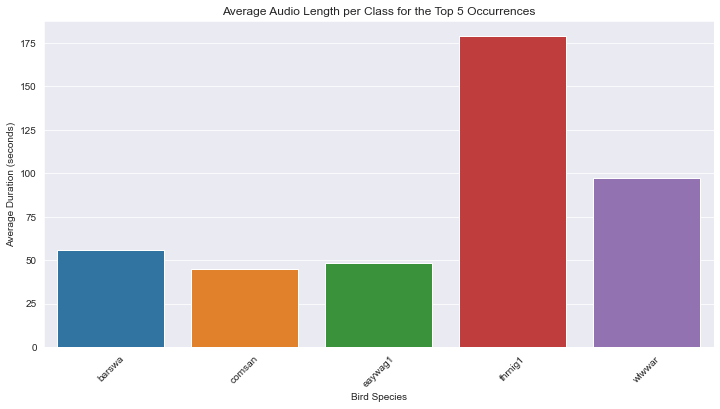

In [36]:
# Plot the average audio length for the top 5 most occurrences
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_durations_top.index, y=mean_durations_top.values)
plt.title("Average Audio Length per Class for the Top 5 Occurrences")
plt.ylabel("Average Duration (seconds)")
plt.xlabel("Bird Species")
plt.xticks(rotation=45)
plt.show()

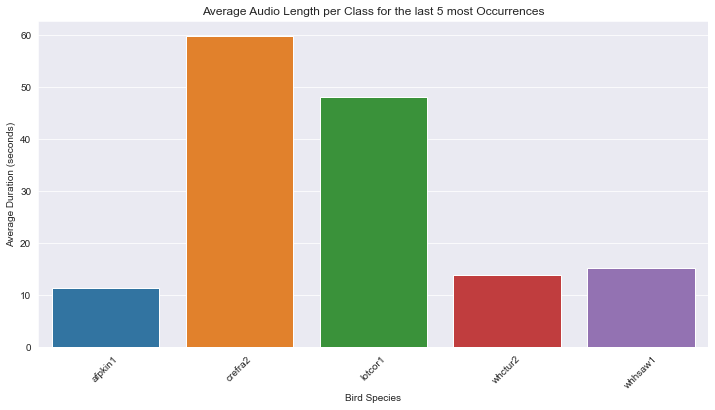

In [37]:
# Plot the average audio length for the last 5 most occurrences
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_durations_last.index, y=mean_durations_last.values)
plt.title("Average Audio Length per Class for the last 5 most Occurrences")
plt.ylabel("Average Duration (seconds)")
plt.xlabel("Bird Species")
plt.xticks(rotation=45)
plt.show()

In [44]:
# Calculate minimum and maximum duration for each class
min_durations_top = train_metadata[train_metadata['primary_label'].isin(top_5_classes)].groupby('primary_label')['duration'].min()
max_durations_top = train_metadata[train_metadata['primary_label'].isin(top_5_classes)].groupby('primary_label')['duration'].max()
# Calculate the deviation for each class
deviation_top = max_durations_top - min_durations_top
min_durations_last = train_metadata[train_metadata['primary_label'].isin(last_5_classes)].groupby('primary_label')['duration'].min()
max_durations_last = train_metadata[train_metadata['primary_label'].isin(last_5_classes)].groupby('primary_label')['duration'].max()
# Calculate the deviation for each class
deviation_last = max_durations_last - min_durations_last

primary_label
afpkin1    0.0
crefra2    0.0
lotcor1    0.0
whctur2    0.0
whhsaw1    0.0
Name: duration, dtype: float64


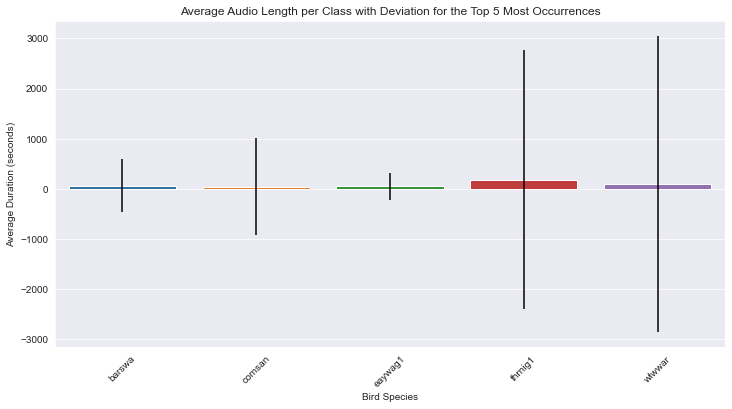

In [39]:
# Plot the average audio length with error bars for deviation
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_durations_top.index, y=mean_durations_top.values, yerr=deviation_top.values, capsize=0.1)
plt.title("Average Audio Length per Class with Deviation for the Top 5 Most Occurrences")
plt.ylabel("Average Duration (seconds)")
plt.xlabel("Bird Species")
plt.xticks(rotation=45)
plt.show()

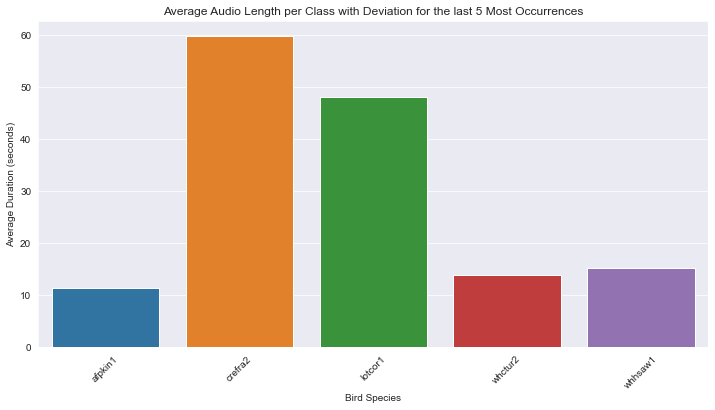

In [40]:
# Plot the average audio length with error bars for deviation
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_durations_last.index, y=mean_durations_last.values, yerr=deviation_last.values, capsize=0.1)
plt.title("Average Audio Length per Class with Deviation for the last 5 Most Occurrences")
plt.ylabel("Average Duration (seconds)")
plt.xlabel("Bird Species")
plt.xticks(rotation=45)
plt.show()

## Plot the distribution of total audio length per class

In [42]:
total_durations_per_class = train_metadata.groupby('primary_label')['duration'].sum()

# Sort the results by duration
total_durations_per_class = total_durations_per_class.sort_values(ascending=False)

# Convert the result to a DataFrame
total_durations_per_class_df = pd.DataFrame(total_durations_per_class).reset_index()

# Display the DataFrame
print(total_durations_per_class_df)

plt.figure(figsize=(15, 5))
sns.barplot(data=total_durations_per_class_df, x='primary_label', y='duration')
plt.xticks(rotation=90)
plt.xlabel("Bird Species")
plt.ylabel("Total Duration (s)")
plt.title("Total Length of Audio Data per Bird Species")
plt.show()